In [1]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Input
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from numpy import mean
from numpy import std
from matplotlib import pyplot
from keras.utils.vis_utils import plot_model
from keras.layers import concatenate

In [2]:
#Load dataset and insert column names, remove the semicolon
#Data preprocessing

column_names= ["user_id", "activity", "timestamp", "axis_x", "axis_y", "axis_z"]
data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None,  _names, comment=";", error_bad_lines=False)

C:\Users\procns\AppData\Local\Temp\ipykernel_7184\608240631.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields, saw 7
Skipping line 832915: expected 6 fields, saw 7
Skipping line 832916: expected 6 fields, saw 7
Skipping line 83

In [3]:
data = data.dropna()
print('Total rows : ', len(data))
data.head()

Total rows :  1086471


user_id activity       timestamp    axis_x     axis_y    axis_z
0       33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1       33  Jogging  49106062271000  5.012288  11.264028  0.953424
2       33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3       33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4       33  Jogging  49106332290000 -1.184970  12.108489  7.205164

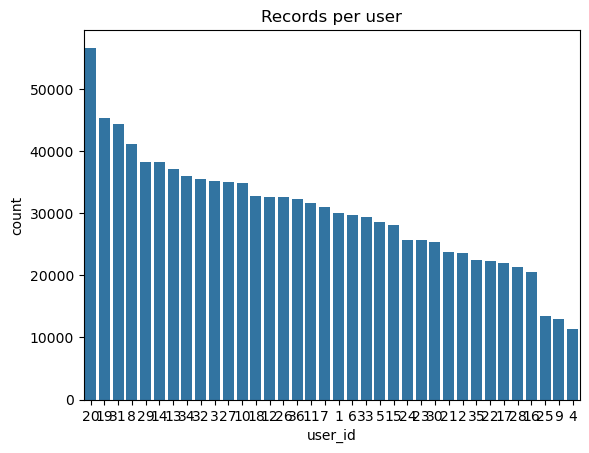

In [4]:
sns.countplot(x = "user_id", data = data, palette = [sns.color_palette()[0]],
              order = data.user_id.value_counts().index)
plt.title("Records per user");

<Axes: xlabel='activity', ylabel='count'>

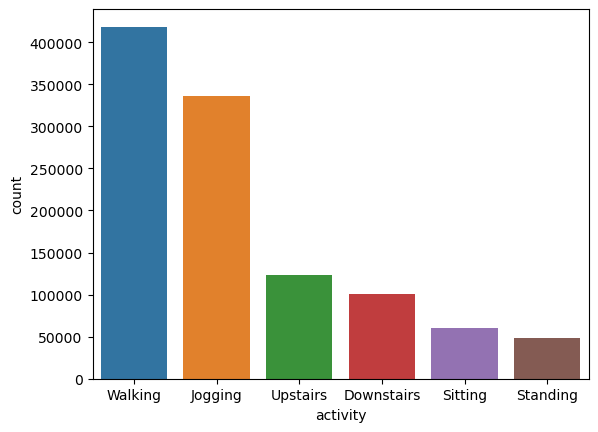

In [5]:
sns.countplot(x = "activity", data = data, order = data.activity.value_counts().index)

In [6]:
# plot a histogram of each variable in the dataset
def plot_variable_distributions(trainX):
 # remove overlap
 cut = int(trainX.shape[1] / 2)
 longX = trainX[:, -cut:, :]
 # flatten windows
 longX = longX.reshape((longX.shape[0] * longX.shape[1], longX.shape[2]))
 print(longX.shape)
 pyplot.figure()
 xaxis = None
 for i in range(longX.shape[1]):
     ax = pyplot.subplot(longX.shape[1], 1, i+1, sharex=xaxis)
     #ax.set_xlim(-1, 1)
     if i == 0:
         xaxis = ax
     pyplot.hist(longX[:, i], bins=100)
 pyplot.show()

(822976, 3)


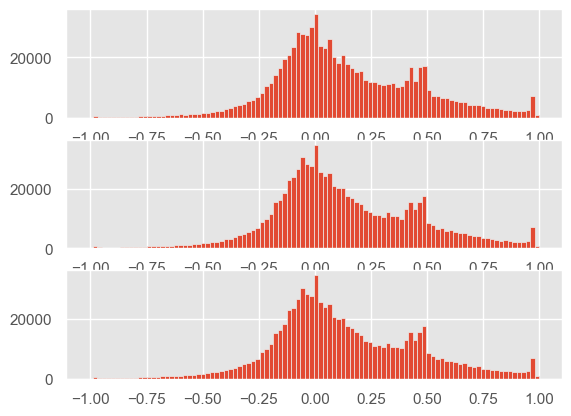

In [25]:
plot_variable_distributions(X_train)

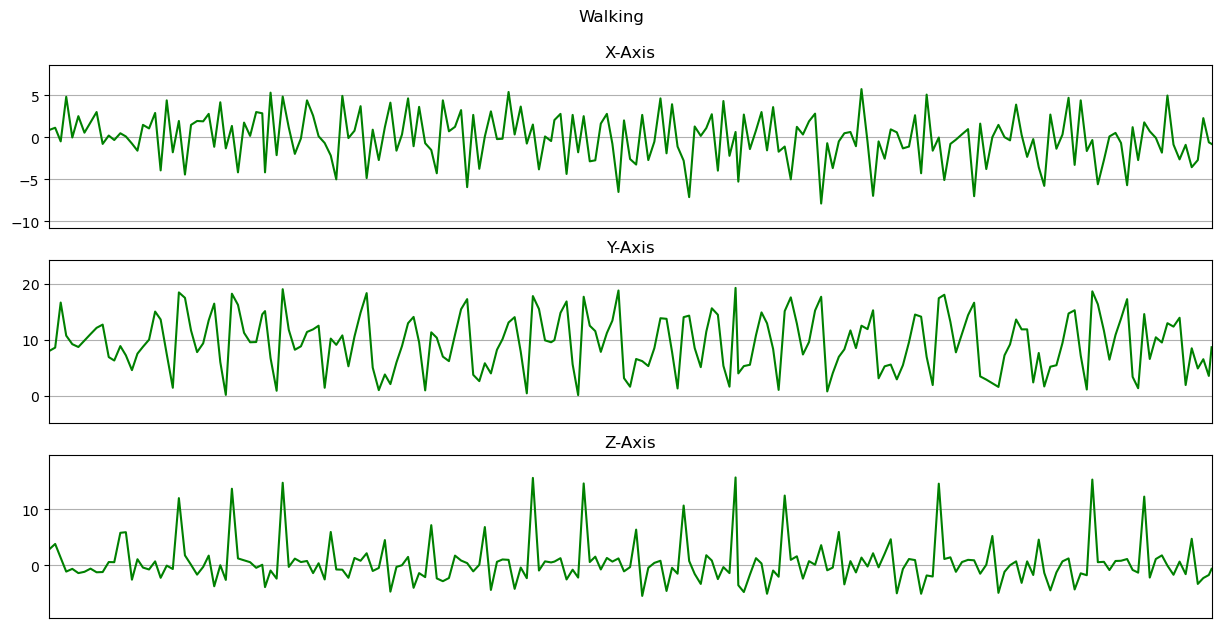

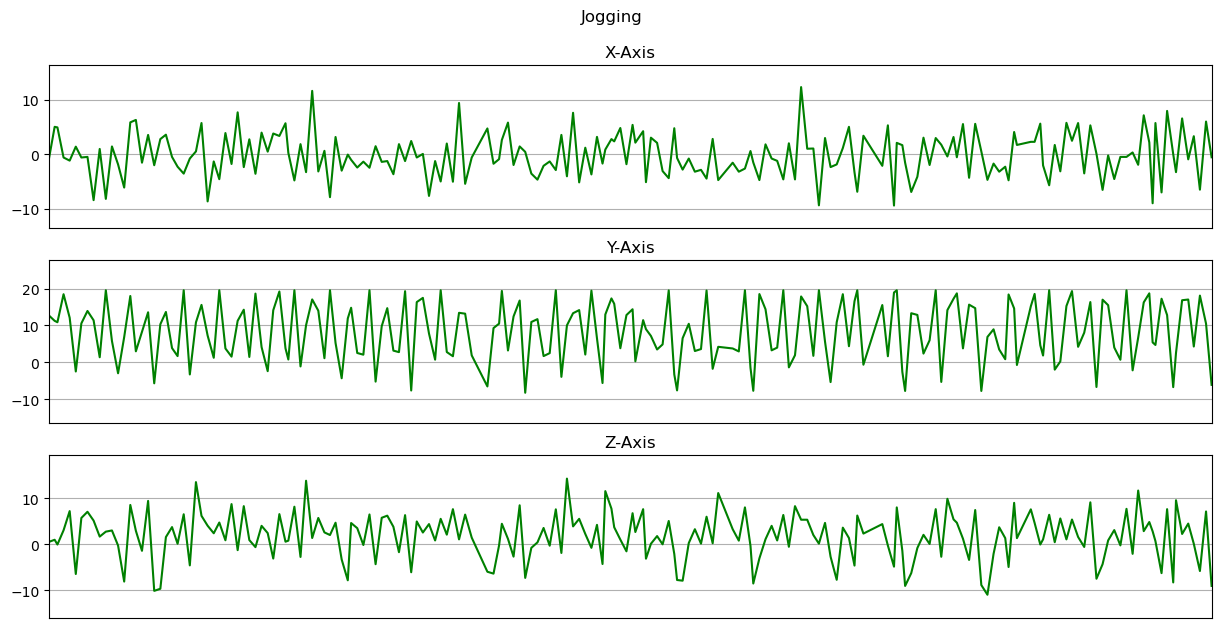

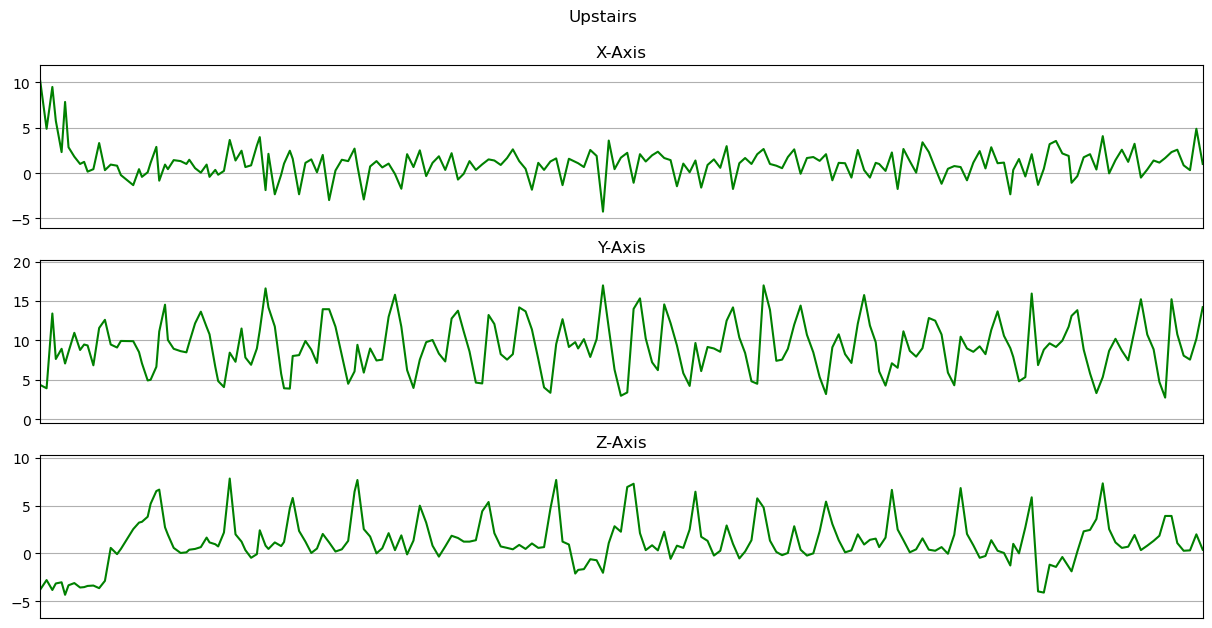

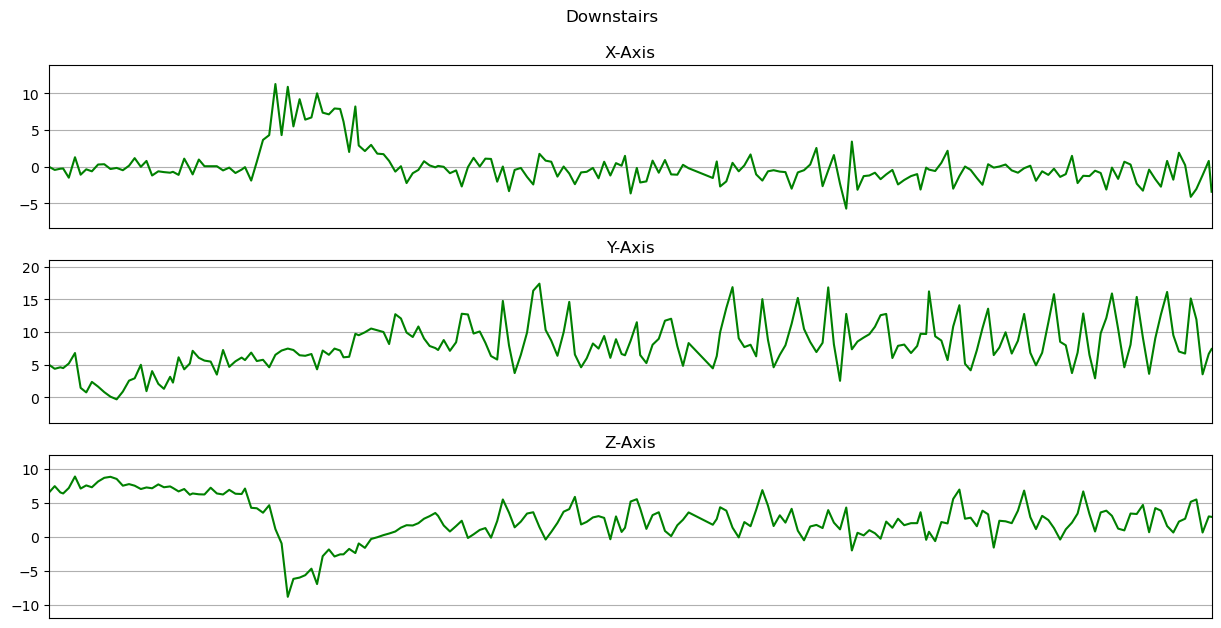

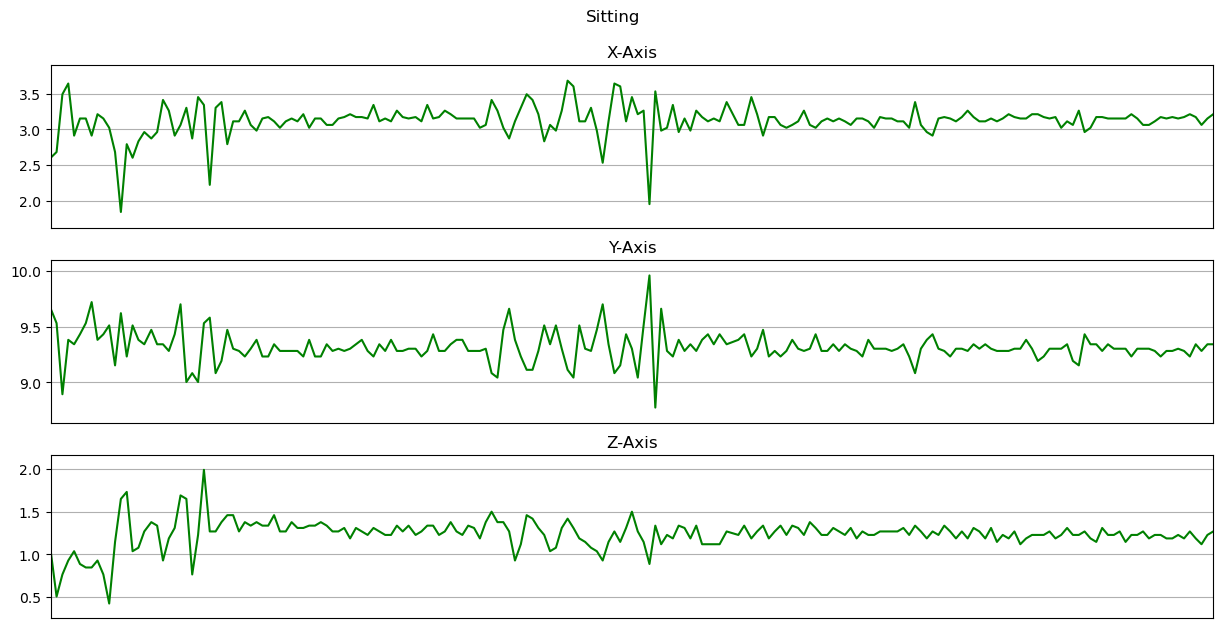

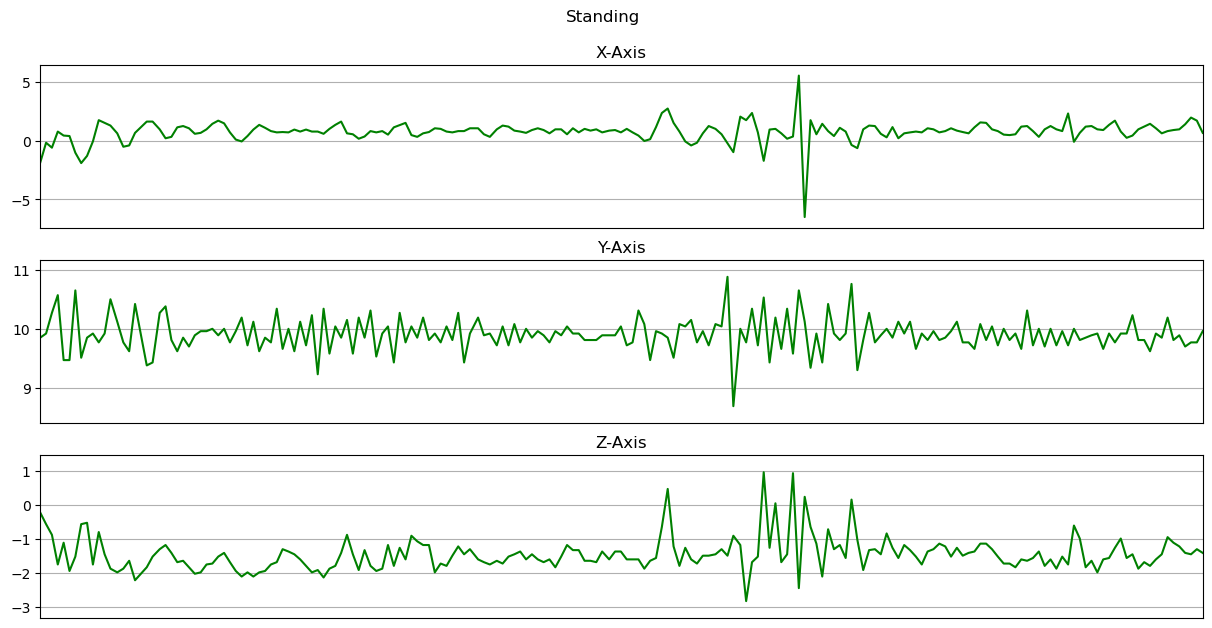

In [8]:
activities = data['activity'].value_counts().index
activities

def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['timestamp'], data['axis_x'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['axis_y'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['axis_z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

Fs = 20
for activity in activities:
    data_for_plot = data[(data['activity'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

In [4]:
import seaborn as sns

pd.options.display.float_format = "{:.1f}".format # Set some standard parameters upfront
sns.set() # Default seaborn look and feel
plt.style.use("ggplot")
# The number of steps within one time segment
TIME_PERIODS = 128
# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is
# no overlap between the segments
STEP_DISTANCE = 64

In [5]:
#show_basic_dataframe_info(data)
data.head(20)

user_id activity       timestamp  axis_x  axis_y  axis_z
0        33  Jogging  49105962326000    -0.7    12.7     0.5
1        33  Jogging  49106062271000     5.0    11.3     1.0
2        33  Jogging  49106112167000     4.9    10.9    -0.1
3        33  Jogging  49106222305000    -0.6    18.5     3.0
4        33  Jogging  49106332290000    -1.2    12.1     7.2
5        33  Jogging  49106442306000     1.4    -2.5    -6.5
6        33  Jogging  49106542312000    -0.6    10.6     5.7
7        33  Jogging  49106652389000    -0.5    13.9     7.1
8        33  Jogging  49106762313000    -8.4    11.4     5.1
9        33  Jogging  49106872299000     1.0     1.4     1.6
10       33  Jogging  49106982315000    -8.2    19.6     2.7
11       33  Jogging  49107092330000     1.4     5.8     3.0
12       33  Jogging  49107202316000    -1.9    -3.0    -0.3
13       33  Jogging  49107312332000    -6.1     6.9    -8.2
14       33  Jogging  49107422348000     5.8    18.0     8.5
15       33  Jogging  49107522293000     6.3     3.0     2.9
16       33  Jogging  49107632339000    -1.6     8.3    -1.5
17       33  Jogging  49107742355000     3.5    13.6     9.4
18       33  Jogging  49107852340000    -2.0    -5.7   -10.2
19       33  Jogging  49107962326000     2.8    10.3    -9.7

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1086471 entries, 0 to 1086471
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user_id    1086471 non-null  int64  
 1   activity   1086471 non-null  object 
 2   timestamp  1086471 non-null  int64  
 3   axis_x     1086471 non-null  float64
 4   axis_y     1086471 non-null  float64
 5   axis_z     1086471 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.0+ MB


In [7]:
from sklearn import preprocessing

# Define column name of the label vector
LABEL = "ActivityEncoded"
# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
data[LABEL] = le.fit_transform(data["activity"].values.ravel())

In [8]:
# Differentiate between test set and training set
data_test = data[data["user_id"] > 28]
data_train = data[data["user_id"] <= 28]

In [9]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
data_train["axis_x"] = data_train["axis_x"] / data["axis_x"].max()
data_train["axis_y"] = data_train["axis_y"] / data["axis_y"].max()
data_train["axis_z"] = data_train["axis_z"] / data["axis_z"].max()
# Round numbers
df_train = data_train.round({"axis_x": 4, "axis_y": 4, "axis_z": 4})


In [10]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
data_test["axis_x"] = data_test["axis_x"] / data["axis_x"].max()
data_test["axis_y"] = data_test["axis_y"] / data["axis_y"].max()
data_test["axis_z"] = data_test["axis_z"] / data["axis_z"].max()
# Round numbers
df_test = data_train.round({"axis_x": 4, "axis_y": 4, "axis_z": 4})


In [11]:
df_train.shape , TIME_PERIODS, STEP_DISTANCE

((823048, 7), 128, 64)

In [12]:
df_test.shape , TIME_PERIODS, STEP_DISTANCE

((823048, 7), 128, 64)

In [17]:
import numpy as np
from scipy import stats
    
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df["axis_x"].values[i: i + time_steps]
        ys = df["axis_y"].values[i: i + time_steps]
        zs = df["axis_z"].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        #stats.mode는 가장 빈도가 높은 값(같으면 앞의 값) 추출
        segments.append([xs, ys, zs])
        labels.append(label)
    print(len(segments))
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    print('reshaped_segments shape : ', reshaped_segments.shape)
    labels = np.asarray(labels)
    print('labels shape :', labels.shape)
    return reshaped_segments, labels

X_train, y_train = create_segments_and_labels(df_train, TIME_PERIODS, STEP_DISTANCE, LABEL)
X_test, y_test = create_segments_and_labels(df_test, TIME_PERIODS, STEP_DISTANCE, LABEL)

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\2729396593.py:17: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)
12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)


In [18]:
print("X_train.shape :", X_train.shape)

print("y_train.shape :", y_train.shape)

print("X_test.shape:", X_test.shape)

print("y_test.shape:", y_test.shape)

X_train.shape : (12859, 128, 3)
y_train.shape : (12859,)
X_test.shape: (12859, 128, 3)
y_test.shape: (12859,)


In [19]:
X_train = X_train.astype("float32")
y_train = y_train.astype("float32")
X_test = X_test.astype("float32")
y_test = y_test.astype("float32")

In [20]:
y_train =  y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [21]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

print(X_train.shape, y_train.shape)

(12859, 128, 3) (12859, 6)


C:\Users\procns\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
#Epoch 500

verbose,epochs,batch_size=1,10,32 

n_timesteps,n_features,n_outputs=X_train.shape[1],X_train.shape[2],y_train.shape[1]

In [26]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(n_outputs, activation='softmax'))

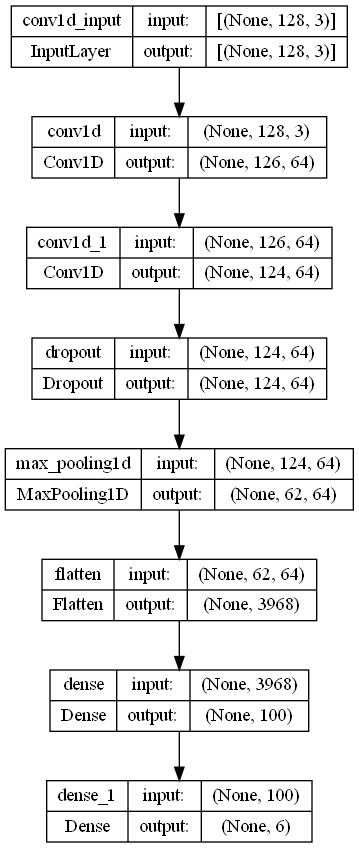

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True)

In [28]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])


In [29]:
history = model.fit(X_train,y_train,epochs=epochs,batch_size=batch_size,verbose=verbose)
model.summary()

Epoch 1/10
402/402 [==============================] - 10s 19ms/step - loss: 0.5109 - accuracy: 0.8177
Epoch 2/10
402/402 [==============================] - 8s 20ms/step - loss: 0.2644 - accuracy: 0.9071
Epoch 3/10
402/402 [==============================] - 8s 20ms/step - loss: 0.1835 - accuracy: 0.9367
Epoch 4/10
402/402 [==============================] - 8s 19ms/step - loss: 0.1483 - accuracy: 0.9466
Epoch 5/10
402/402 [==============================] - 8s 19ms/step - loss: 0.1248 - accuracy: 0.9558
Epoch 6/10
402/402 [==============================] - 8s 19ms/step - loss: 0.1028 - accuracy: 0.9630
Epoch 7/10
402/402 [==============================] - 8s 19ms/step - loss: 0.0832 - accuracy: 0.9704
Epoch 8/10
402/402 [==============================] - 8s 19ms/step - loss: 0.0697 - accuracy: 0.9759
Epoch 9/10
402/402 [==============================] - 8s 19ms/step - loss: 0.0588 - accuracy: 0.9801
Epoch 10/10
402/402 [==============================] - 8s 20ms/step - loss: 0.0576 - accur

In [30]:
base_loss,base_accuracy=model.evaluate(X_test,y_test,batch_size=batch_size,verbose=1)

#cnn_file='CNN_Model.h5'
#tf.keras.models.save_model(model, cnn_file, include_optimizer=False)
#print('model saved at ', cnn_file)
#score,keras_file=evaluate_model(trainX,trainy,testX,testy)
score=base_accuracy*100
print('Accuracy >{:f}'.format(score))
print('Base Loss >{:.2f}'.format(base_loss))

402/402 [==============================] - 3s 6ms/step - loss: 0.0304 - accuracy: 0.9942
Accuracy >99.416751
Base Loss >0.03


# 함수 사용하여 구성

In [31]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 model = Sequential()
 model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [32]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [33]:
# run an experiment
def run_experiment(repeats=10):
    # load data
    trainX, trainy, testX, testy = load_dataset()
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)

In [59]:
# load the dataset, returns train and test X and y elements
def load_dataset(prefix=''):
    #Load dataset and insert column names, remove the semicolon
    column_names= ["user_id", "activity", "timestamp", "axis_x", "axis_y", "axis_z"]
    data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
    TIME_PERIODS = 128
    STEP_DISTANCE = 64
    # The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is
    # no overlap between the segments
    
    LABEL = "ActivityEncoded"
    # Transform the labels from String to Integer via LabelEncoder
    le = preprocessing.LabelEncoder()
    # Add a new column to the existing DataFrame with the encoded values
    data[LABEL] = le.fit_transform(data["activity"].values.ravel())
    #data_normalize
    data = nomalize_data(data)
    data_test = data[data["user_id"] > 28]
    data_train = data[data["user_id"] <= 28]
    
    #create_segment
    X_train, y_train = create_segments_and_labels(data_train, TIME_PERIODS, STEP_DISTANCE, LABEL)
    X_test, y_test = create_segments_and_labels(data_test, TIME_PERIODS, STEP_DISTANCE, LABEL)
    
    y_train, y_test  = onehotencoding_data(y_train, y_test)
    return X_train, y_train, X_test, y_test

In [35]:
def nomalize_data(data):
    pd.options.mode.chained_assignment = None  # default='warn'
    data["axis_x"] = data["axis_x"] / data["axis_x"].max()
    data["axis_y"] = data["axis_y"] / data["axis_y"].max()
    data["axis_z"] = data["axis_z"] / data["axis_z"].max()
    # Round numbers
    data = data_train.round({"axis_x": 4, "axis_y": 4, "axis_z": 4})
    return data

In [36]:
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df["axis_x"].values[i: i + time_steps]
        ys = df["axis_y"].values[i: i + time_steps]
        zs = df["axis_z"].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        #stats.mode는 가장 빈도가 높은 값(같으면 앞의 값) 추출
        segments.append([xs, ys, zs])
        labels.append(label)
    print('segmants : ',len(segments))
    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    print('reshaped_segments shape : ', reshaped_segments.shape)
    labels = np.asarray(labels)
    print('labels shape :', labels.shape)
    return reshaped_segments, labels

In [37]:
def onehotencoding_data(train, test):
    train =  train.reshape(-1,1)
    test = test.reshape(-1,1)
    enc = OneHotEncoder(handle_unknown = "ignore", sparse = False)
    enc = enc.fit(train)

    train = enc.transform(train)
    test = enc.transform(test)
    return train, test

In [38]:
run_experiment()

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\2128631947.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields, saw 7
Skipping line 832915: expected 6 fields, saw 7
Skipping line 832916: expected 6 fields, saw 7
Skipping line 8

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\352160800.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)
segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)


C:\Users\procns\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


>#1: 99.479
>#2: 99.572
>#3: 98.989
>#4: 98.911
>#5: 99.347
>#6: 99.355
>#7: 99.471
>#8: 99.269
>#9: 99.603
>#10: 99.580
[99.47896599769592, 99.57228302955627, 98.98903369903564, 98.91126751899719, 99.3467628955841, 99.35453534126282, 99.47118759155273, 99.26899671554565, 99.60339069366455, 99.58006143569946]
Accuracy: 99.358% (+/-0.229)


# Number of Filters

In [39]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_filters):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 model = Sequential()
 model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=n_filters, kernel_size=3, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [40]:
# summarize scores
def summarize_results(scores, params):
 print(scores, params)
 # summarize mean and standard deviation
 for i in range(len(scores)):
     m, s = mean(scores[i]), std(scores[i])
     print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
 # boxplot of scores
 pyplot.boxplot(scores, labels=params)
 #pyplot.savefig('exp_cnn_filters.png')

In [41]:
# run an experiment
def run_experiment(params, repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # test each parameter
 all_scores = list()
 for p in params:
     # repeat experiment
     scores = list()
     for r in range(repeats):
         score = evaluate_model(trainX, trainy, testX, testy, p)
         score = score * 100.0
         print('>p=%d #%d: %.3f' % (p, r+1, score))
         scores.append(score)
     all_scores.append(scores)
 # summarize results
 summarize_results(all_scores, params)

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\2128631947.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields, saw 7
Skipping line 832915: expected 6 fields, saw 7
Skipping line 832916: expected 6 fields, saw 7
Skipping line 8

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\352160800.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)
segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)


C:\Users\procns\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


>p=8 #1: 94.059
>p=8 #2: 96.018
>p=8 #3: 95.575
>p=8 #4: 95.342
>p=8 #5: 91.593
>p=8 #6: 91.220
>p=8 #7: 93.701
>p=8 #8: 95.762
>p=8 #9: 93.063
>p=8 #10: 92.153
>p=16 #1: 97.185
>p=16 #2: 97.185
>p=16 #3: 97.123
>p=16 #4: 96.415
>p=16 #5: 97.496
>p=16 #6: 97.978
>p=16 #7: 97.457
>p=16 #8: 97.185
>p=16 #9: 97.371
>p=16 #10: 96.990
>p=32 #1: 98.756
>p=32 #2: 98.546
>p=32 #3: 98.600
>p=32 #4: 95.692
>p=32 #5: 98.095
>p=32 #6: 98.305
>p=32 #7: 98.204
>p=32 #8: 98.865
>p=32 #9: 98.585
>p=32 #10: 98.468
>p=64 #1: 99.246
>p=64 #2: 99.541
>p=64 #3: 99.051
>p=64 #4: 98.686
>p=64 #5: 98.351
>p=64 #6: 98.802
>p=64 #7: 99.588
>p=64 #8: 99.005
>p=64 #9: 99.549
>p=64 #10: 99.230
>p=128 #1: 99.611
>p=128 #2: 99.603
>p=128 #3: 99.806
>p=128 #4: 99.806
>p=128 #5: 99.565
>p=128 #6: 99.728
>p=128 #7: 99.401
>p=128 #8: 99.502
>p=128 #9: 99.681
>p=128 #10: 99.277
>p=256 #1: 99.736
>p=256 #2: 99.891
>p=256 #3: 99.728
>p=256 #4: 99.619
>p=256 #5: 99.238
>p=256 #6: 99.876
>p=256 #7: 99.518
>p=256 #8: 99.541
>

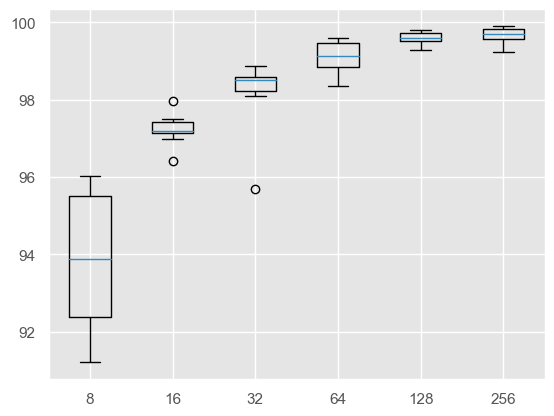

In [43]:
# run the experiment
n_params = [8, 16, 32, 64, 128, 256]
run_experiment(n_params)

# Size of kernel

In [44]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy, n_kernel):
 verbose, epochs, batch_size = 0, 15, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 model = Sequential()
 model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu', input_shape=(n_timesteps,n_features)))
 model.add(Conv1D(filters=64, kernel_size=n_kernel, activation='relu'))
 model.add(Dropout(0.5))
 model.add(MaxPooling1D(pool_size=2))
 model.add(Flatten())
 model.add(Dense(100, activation='relu'))
 model.add(Dense(n_outputs, activation='softmax'))
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
 return accuracy

In [45]:
# summarize scores
def summarize_results(scores, params):
 print(scores, params)
 # summarize mean and standard deviation
 for i in range(len(scores)):
     m, s = mean(scores[i]), std(scores[i])
     print('Param=%d: %.3f%% (+/-%.3f)' % (params[i], m, s))
 # boxplot of scores
 pyplot.boxplot(scores, labels=params)
 #pyplot.savefig('exp_cnn_kernel.png')

In [46]:
# run an experiment
def run_experiment(params, repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # test each parameter
 all_scores = list()
 for p in params:
 # repeat experiment
     scores = list()
     for r in range(repeats):
         score = evaluate_model(trainX, trainy, testX, testy, p)
         score = score * 100.0
         print('>p=%d #%d: %.3f' % (p, r+1, score))
         scores.append(score)
     all_scores.append(scores)
 # summarize results
 summarize_results(all_scores, params)

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\2128631947.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields, saw 7
Skipping line 832915: expected 6 fields, saw 7
Skipping line 832916: expected 6 fields, saw 7
Skipping line 8

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\352160800.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)
segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)


C:\Users\procns\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


>p=2 #1: 99.666
>p=2 #2: 98.958
>p=2 #3: 99.588
>p=2 #4: 99.176
>p=2 #5: 99.821
>p=2 #6: 99.479
>p=2 #7: 99.634
>p=2 #8: 99.113
>p=2 #9: 99.463
>p=2 #10: 99.370
>p=3 #1: 98.740
>p=3 #2: 99.922
>p=3 #3: 99.728
>p=3 #4: 99.860
>p=3 #5: 99.736
>p=3 #6: 99.720
>p=3 #7: 99.495
>p=3 #8: 99.642
>p=3 #9: 99.806
>p=3 #10: 99.899
>p=5 #1: 99.876
>p=5 #2: 99.736
>p=5 #3: 99.907
>p=5 #4: 99.790
>p=5 #5: 99.844
>p=5 #6: 99.588
>p=5 #7: 99.821
>p=5 #8: 99.673
>p=5 #9: 99.821
>p=5 #10: 99.650
>p=7 #1: 99.277
>p=7 #2: 99.860
>p=7 #3: 99.743
>p=7 #4: 99.767
>p=7 #5: 99.907
>p=7 #6: 99.790
>p=7 #7: 98.973
>p=7 #8: 99.541
>p=7 #9: 99.938
>p=7 #10: 99.891
>p=11 #1: 99.837
>p=11 #2: 99.736
>p=11 #3: 99.844
>p=11 #4: 99.005
>p=11 #5: 99.339
>p=11 #6: 99.246
>p=11 #7: 99.572
>p=11 #8: 99.782
>p=11 #9: 99.813
>p=11 #10: 99.759
[[99.6656060218811, 98.95792603492737, 99.58783984184265, 99.17567372322083, 99.82113838195801, 99.47896599769592, 99.63449835777283, 99.11346435546875, 99.46340918540955, 99.3700921535

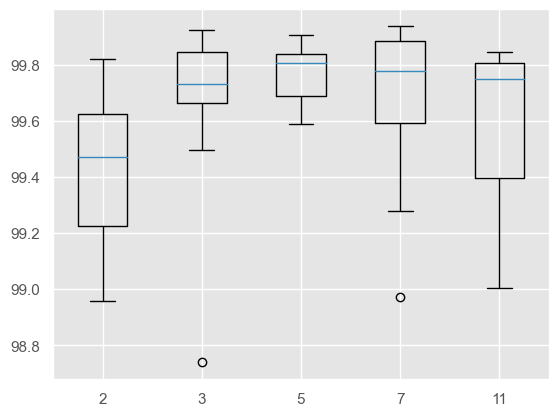

In [47]:
# run the experiment
n_params = [2, 3, 5, 7, 11]
run_experiment(n_params)

# Multi-Headed Convolutional Neural Network

In [48]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
 verbose, epochs, batch_size = 0, 10, 32
 n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
 # head 1
 inputs1 = Input(shape=(n_timesteps,n_features))
 conv1 = Conv1D(filters=64, kernel_size=3, activation='relu')(inputs1)
 drop1 = Dropout(0.5)(conv1)
 pool1 = MaxPooling1D(pool_size=2)(drop1)
 flat1 = Flatten()(pool1)
 # head 2
 inputs2 = Input(shape=(n_timesteps,n_features))
 conv2 = Conv1D(filters=64, kernel_size=5, activation='relu')(inputs2)
 drop2 = Dropout(0.5)(conv2)
 pool2 = MaxPooling1D(pool_size=2)(drop2)
 flat2 = Flatten()(pool2)
 # head 3
 inputs3 = Input(shape=(n_timesteps,n_features))
 conv3 = Conv1D(filters=64, kernel_size=11, activation='relu')(inputs3)
 drop3 = Dropout(0.5)(conv3)
 pool3 = MaxPooling1D(pool_size=2)(drop3)
 flat3 = Flatten()(pool3)
 # merge
 merged = concatenate([flat1, flat2, flat3])
 # interpretation
 dense1 = Dense(100, activation='relu')(merged)
 outputs = Dense(n_outputs, activation='softmax')(dense1)
 model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
 # save a plot of the model
 #plot_model(model, show_shapes=True, to_file='multichannel.png')
 plot_model(model, show_shapes=True)
 model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
 # fit network
 model.fit([trainX,trainX,trainX], trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
 # evaluate model
 _, accuracy = model.evaluate([testX,testX,testX], testy, batch_size=batch_size, verbose=0)
 return accuracy

In [49]:
# summarize scores
def summarize_results(scores):
 print(scores)
 m, s = mean(scores), std(scores)
 print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

In [50]:
# run an experiment
def run_experiment(repeats=10):
 # load data
 trainX, trainy, testX, testy = load_dataset()
 # repeat experiment
 scores = list()
 for r in range(repeats):
     score = evaluate_model(trainX, trainy, testX, testy)
     score = score * 100.0
     print('>#%d: %.3f' % (r+1, score))
     scores.append(score)
 # summarize results
 summarize_results(scores)

In [58]:
# run the experiment
run_experiment()

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\2128631947.py:5: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  data = pd.read_csv('C:/Users/procns/Desktop/인공지능/HAR/WISDM/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names, comment=";", error_bad_lines=False)
Skipping line 832904: expected 6 fields, saw 7
Skipping line 832905: expected 6 fields, saw 7
Skipping line 832906: expected 6 fields, saw 7
Skipping line 832907: expected 6 fields, saw 7
Skipping line 832908: expected 6 fields, saw 7
Skipping line 832909: expected 6 fields, saw 7
Skipping line 832910: expected 6 fields, saw 7
Skipping line 832911: expected 6 fields, saw 7
Skipping line 832912: expected 6 fields, saw 7
Skipping line 832913: expected 6 fields, saw 7
Skipping line 832914: expected 6 fields, saw 7
Skipping line 832915: expected 6 fields, saw 7
Skipping line 832916: expected 6 fields, saw 7
Skipping line 8

C:\Users\procns\AppData\Local\Temp\ipykernel_4280\352160800.py:14: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  label = stats.mode(df[label_name][i: i + time_steps])[0][0]


segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)
segmants :  12859
reshaped_segments shape :  (12859, 128, 3)
labels shape : (12859,)


C:\Users\procns\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


>#1: 98.764
>#2: 98.577
>#3: 99.572
>#4: 98.935
>#5: 98.919
>#6: 99.300
>#7: 98.662
>#8: 98.227
>#9: 98.981
>#10: 98.624
[98.76351356506348, 98.5768735408783, 99.57228302955627, 98.93459677696228, 98.91904592514038, 99.30009841918945, 98.66241812705994, 98.22692275047302, 98.98125529289246, 98.62353205680847]
Accuracy: 98.856% (+/-0.362)
